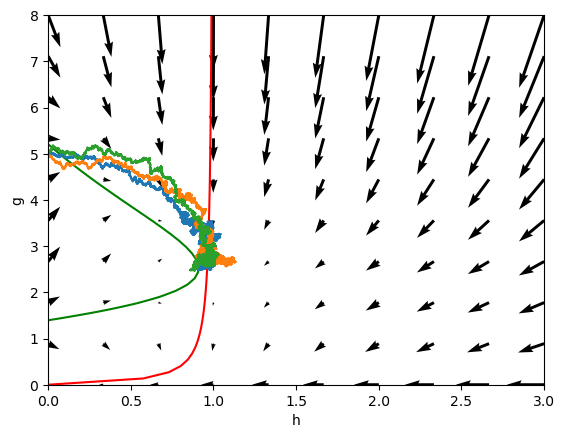

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 19 14:02:25 2022

@author: Anton Grisheshckin
"""
#%%Importing packages#
import numpy as np
import matplotlib.pyplot as plt
#%% Model variables#
class modelvar :
    V = 0.55 #Maximal amplitude for synthesis [AU]hr^-1   
    # Hill parameters    
    n = 3  # Hill function power in g eqn
    k1 = 2 #[AU]
    k2 = 2 #[AU]
    k3 = 0.1 #[AU]
    ################
    ψ = 0.1 # Max amplification for h [AU]hr^-1
    γ1 = 0.1 #Dilution rate hr^-1
    γ2 = 0.1
    I = 0 # dsRNA trigger [AU]hr^-1
    σ1 = 0.02 # Noise amplitudes hr^-1/2
    σ2 = 0.02 
##########################
#%%Deterministic part of the code#
def Hill(top, bottom, power):
    "Creates a Hill function"
    return (top**power)/(top**power+bottom**power)

def f1(g,h,MaxAmpl):
    "Deterministic part of the first equation (dg/dt)"
    return (modelvar.I+MaxAmpl*Hill(g,modelvar.k1,modelvar.n)*Hill(modelvar.k2,h,1)-modelvar.γ1*g)

def f2(g,h) :
    "Determenistic part of the second equation (dh/dt)"
    return (modelvar.ψ*(g/(modelvar.k3+g))-modelvar.γ2*h)


def model(x, t = 0):
    'Toggle Inhibitor model'
    h, g = x
    dh = f2(g,h)
    dg = f1(g,h,modelvar.V)
    return np.array([dh, dg])

def phase_plane_plot(model, range_x = (0,3), range_y = (0,8),
                     num_grid_points = 60, arrow_grid_points = 10):
    '''
    Original function done by Dominik Krzeminski (dokato)'
    Input:
    -----
      *model* : function
        function that takes numpy.array as input with two elements
        representing two state variables
      *range_x* = (-1, 1) : tuple
        range of x axis
      *range_y* = None : tuple
        range of yints* = 50 : int axis; if None, the same range as *range_x*
      *num_grid_points* = 50 : int
        number of samples on grid
      *arrow_grid_points* : int
        numeber of points for arrows to go on the grid w.r.t the axis (i.e.number of actual arrows is this num sqauared)
    '''
    if range_y is None:
        range_y = range_x
    x_ = np.linspace(range_x[0], range_x[1], num_grid_points)                                                             
    y_ = np.linspace(range_y[0], range_y[1], num_grid_points)                                                             
    
    arrowx_ = np.linspace(range_x[0], range_x[1], arrow_grid_points)
    arrowy_ = np.linspace(range_y[0], range_y[1], arrow_grid_points)
    
    
    grid = np.meshgrid(x_, y_)
    
    arrowgrid=np.meshgrid(arrowx_, arrowy_)
    
    dfmat = np.zeros((num_grid_points, num_grid_points, 2))
    arrowdfmat=np.zeros((arrow_grid_points, arrow_grid_points,2))
    for nx in range(num_grid_points):
        for ny in range(num_grid_points):
            df = model([grid[0][nx,ny], grid[1][nx,ny]])
            dfmat[nx, ny, 0] = df[0]
            dfmat[nx, ny, 1] = df[1]
            
    for nx in range(arrow_grid_points):
        for ny in range(arrow_grid_points):
            arrowdf = model([arrowgrid[0][nx,ny], arrowgrid[1][nx,ny]])
            arrowdfmat[nx, ny, 0] = arrowdf[0]
            arrowdfmat[nx, ny, 1] = arrowdf[1]

    plt.quiver(arrowgrid[0], arrowgrid[1], arrowdfmat[:, :, 0], arrowdfmat[:, :, 1],)
    plt.contour(grid[0], grid[1], dfmat[:, :, 0], [0], colors = 'r')
    plt.contour(grid[0], grid[1], dfmat[:, :, 1], [0], colors = 'g')


#%%Stochastic part of the code #

def mu1(g: float,h : float,  _t: float, MaxAmpl) -> float:
    """
    Implement the drift part of the dg equation
    """
    return (modelvar.I+MaxAmpl*Hill(g,modelvar.k1,modelvar.n)*Hill(modelvar.k2,h,1)-modelvar.γ1*g)

def mu2(g: float, h : float,  _t: float) -> float:
    """
    Implement the drift part of the dh equation
    """
    return (modelvar.ψ*(g/(modelvar.k3+g))-modelvar.γ2*h)
def sigma1(g: float, h:float,  _t: float) -> float:
    """
    Implement the BM part of dg equation
    """
    return modelvar.σ1 * g

def sigma2(g: float, h:float,  _t: float) -> float:
    """
    Implement the BM part of dh equation
    """
    return modelvar.σ2 * h

def dW1(delta_t: float) -> float:
    """
    Sample a random number at each call.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def dW2(delta_t: float) -> float:
    """
    Sample a random number at each call independent of dW1.
    """
    return np.random.normal(loc=0.0, scale=np.sqrt(delta_t))

def run_simulation(initial_time, end_time,number_of_grid_points,X_INIT,Y_INIT):
    """
    Return the result of one full simulation.
    """
    N      = number_of_grid_points
    DT     = float(end_time - initial_time) / N
    TS = np.arange(initial_time, end_time + DT, DT)
    xs= np.zeros(N+1)
    ys = np.zeros(N + 1)
    xs[0]= X_INIT
    ys[0] = Y_INIT
    for i in range(1, TS.size):
        t = initial_time + (i - 1) * DT
        y = ys[i - 1]
        x=xs[i-1]
        ys[i] = y + mu1(y,x,t,modelvar.V) * DT + sigma1(y,x,t) * dW1(DT)
        xs[i]= x + mu2(y,x,t)*DT + sigma2(y,x,t)*dW2(DT)
    return xs, ys

def plot_simulations(num_sims: int) -> None:
    """
    Plot several simulations in one image.
    """
    for _ in range(num_sims):
        plt.plot(*run_simulation(0,100,20000,0,5))

    plt.xlabel("h")
    plt.ylabel("g")
    plt.xlim([0,3])
    plt.show()
#%%Main body #

if __name__=="__main__":
    phase_plane_plot(model, range_x = (0, 3))
    NUM_SIMS = 3
    plot_simulations(NUM_SIMS)